# SDOH Exploratory Data Analysis

## About This File

This notebook provides a comprehensive exploratory analysis of Social Determinants of Health (SDOH) variables and their relationships to MRSA infection rates 

### Purpose
- **Understand variable relationships**: Identify correlations and clusters among SDOH factors
- **Assess multicollinearity**: Detect redundant features using Variance Inflation Factor (VIF) analysis
- **Dimension reduction**: Apply PCA to extract latent patterns and reduce feature space
- **Temporal stability**: Evaluate how SDOH factors change year-over-year and their predictive reliability
- **Feature selection**: Guide model development by identifying high-quality predictors

### Key Analyses

1. **Correlation Heatmap**: Visualizes pairwise correlations among all SDOH variables to identify strong positive/negative relationships
2. **Network Graph Analysis**: Displays variables strongly correlated (|r| > 0.6) as a network, highlighting central variables and clusters
3. **Variance Inflation Factor (VIF)**: Quantifies multicollinearity; features with VIF > 10 are considered problematic for modeling
4. **Principal Component Analysis (PCA)**: 
   - Identifies the principal components capturing the most variance
   - Interprets loadings to understand which original variables drive each component
   - Determines how many components are needed to retain meaningful variance
5. **Year-over-Year Stability Analysis**: Classifies variables as Stable, Moderate, or Highly Variable to assess their reliability as predictors

### Key Findings

- **High multicollinearity detected**: Population, income percentiles, and racial composition variables show VIF > 100
- **Strong clusters identified**: 
  - Socioeconomic hardship (unemployment, poverty, income inequality)
  - Behavioral health (smoking, physical inactivity, excessive drinking)
  - Racial/ethnic composition (naturally correlated as they sum to 100%)
- **Variable stability varies**: Some factors (e.g., population, labor force) are stable; others (PM2.5, unemployment) show high year-to-year volatility
- **Recommendation**: Apply feature selection or dimensionality reduction before modeling to improve stability and interpretability

### Data Source
- **Input file**: `combined_measure_data.csv` (cleaned and merged SDOH measures across multiple years)
- **Time period**: 2017–2024
- **Geographic unit**: California counties

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6]:
mrsa_df = pd.read_csv(f'../../data/sdoh_data/clean_data/combined_measure_data.csv')
mrsa_df = mrsa_df.drop('% Uninsured_y', axis=1)
mrsa_df

Year    FIPS     County       State  ranked_Population  % Some College  \
0    2017  6001.0    Alameda  California           484192.0       72.871506   
1    2017  6003.0     Alpine  California              223.0       61.434978   
2    2017  6005.0     Amador  California             7586.0       56.802004   
3    2017  6007.0      Butte  California            50268.0       68.699769   
4    2017  6009.0  Calaveras  California             7860.0       58.880407   
..    ...     ...        ...         ...                ...             ...   
465  2024  6107.0     Tulare  California           280911.0       51.364628   
466  2024  6109.0   Tuolumne  California            42078.0       65.049458   
467  2024  6111.0    Ventura  California           575974.0       65.706353   
468  2024  6113.0       Yolo  California           129126.0       71.899769   
469  2024  6115.0       Yuba  California            51600.0       61.814737   

     Income Ratio  20th Percentile Income  80th Percentile Income  \
0        5.366753                 28526.0                153092.0   
1        5.441321                 18286.0                 99500.0   
2        4.612793                 22324.0                102976.0   
3        5.288328                 17272.0                 91340.0   
4        4.949277                 22258.0                110161.0   
..            ...                     ...                     ...   
465      4.436695                 28173.0                124995.0   
466      4.415744                 30437.0                134402.0   
467      4.353270                 44609.0                194195.0   
468      5.840881                 29789.0                173994.0   
469      4.442369                 27520.0                122254.0   

     % Children in Poverty  ...     % Rural  % 65 and over  % Hispanic  \
0                     13.8  ...    0.388606      12.740147   22.588366   
1                     35.7  ...  100.000000      21.981982    9.189189   
2                     19.5  ...   60.423722      25.780384   13.521256   
3                     23.8  ...   18.901818      17.542622   15.749453   
4                     21.2  ...   75.409189      25.865530   11.524047   
..                     ...  ...         ...            ...         ...   
465                   24.3  ...   57.032615      11.819434   66.993408   
466                   15.1  ...  100.000000      28.114284   13.616108   
467                   12.5  ...   20.056138      17.503138   44.462861   
468                   14.5  ...   47.837109      13.464196   32.292731   
469                   19.0  ...    3.366859      13.243980   31.152888   

       % Asian  % Non-Hispanic White  % Not Proficient in English   % Female  \
0    29.518287             32.484808                     9.149506  50.949906   
1     1.171171             66.936937                     1.190476  47.387387   
2     1.470231             79.103267                     1.151357  46.741980   
3     4.683001             73.031485                     2.385830  50.515281   
4     1.597216             81.792630                     0.770412  50.044615   
..         ...                   ...                          ...        ...   
465   4.155010             26.013100                    12.703669  49.812373   
466   1.606426             78.801049                     0.604448  48.532028   
467   8.191039             42.996739                     8.864751  50.165204   
468  16.035837             43.991626                     6.299472  51.371587   
469   8.352509             50.224173                     4.372769  48.977583   

     Segregation Index  Drug Overdose Mortality Rate  Homicide Rate  
0            34.274171                     11.163981       7.700000  
1                  NaN                           NaN            NaN  
2            21.222035                     24.487131       5.000000  
3            27.461189                     29.177869       3.900000  
4            26.604710     

# Correlation Heatmap of variables

Strong positive clusters:

- % Unemployed, % Children in Poverty, and Income Ratio form a clear economic hardship group.

- % Physically Inactive, % Smokers, and % Excessive Drinking are correlated — forming a behavioral health group.

Strong negative correlations:

- % Some College tends to be inversely correlated with poverty and unemployment → higher education = better socioeconomic stability.

- % Uninsured shows moderate inverse correlation with Dentist Rate → better healthcare access = lower uninsured rates.

Weak or independent variables:

- Environmental metrics like Average Daily PM2.5 and % Long Commute appear relatively independent from other SDOH variables.

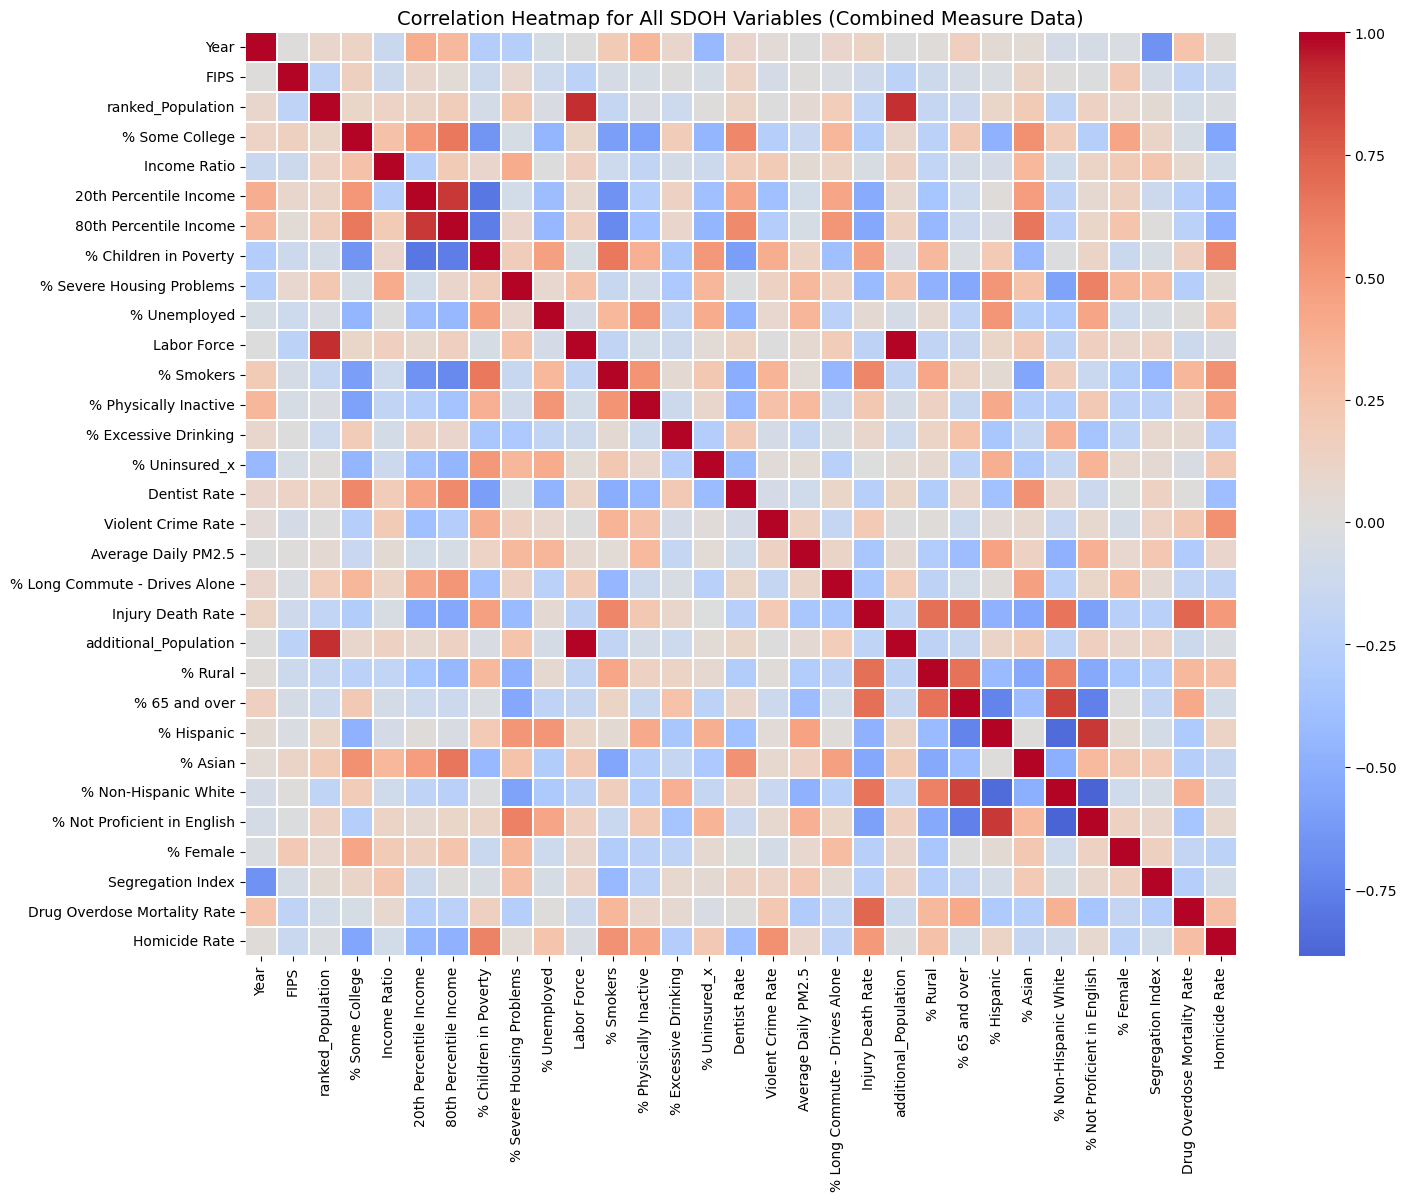

In [4]:
plt.figure(figsize=(16, 12))
corr_matrix = mrsa_df.select_dtypes(include=[np.number]).corr()

sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.3, annot=False)
plt.title("Correlation Heatmap for All SDOH Variables (Combined Measure Data)", fontsize=14)
plt.show()

# Correlation clustering to uncover latent groupings

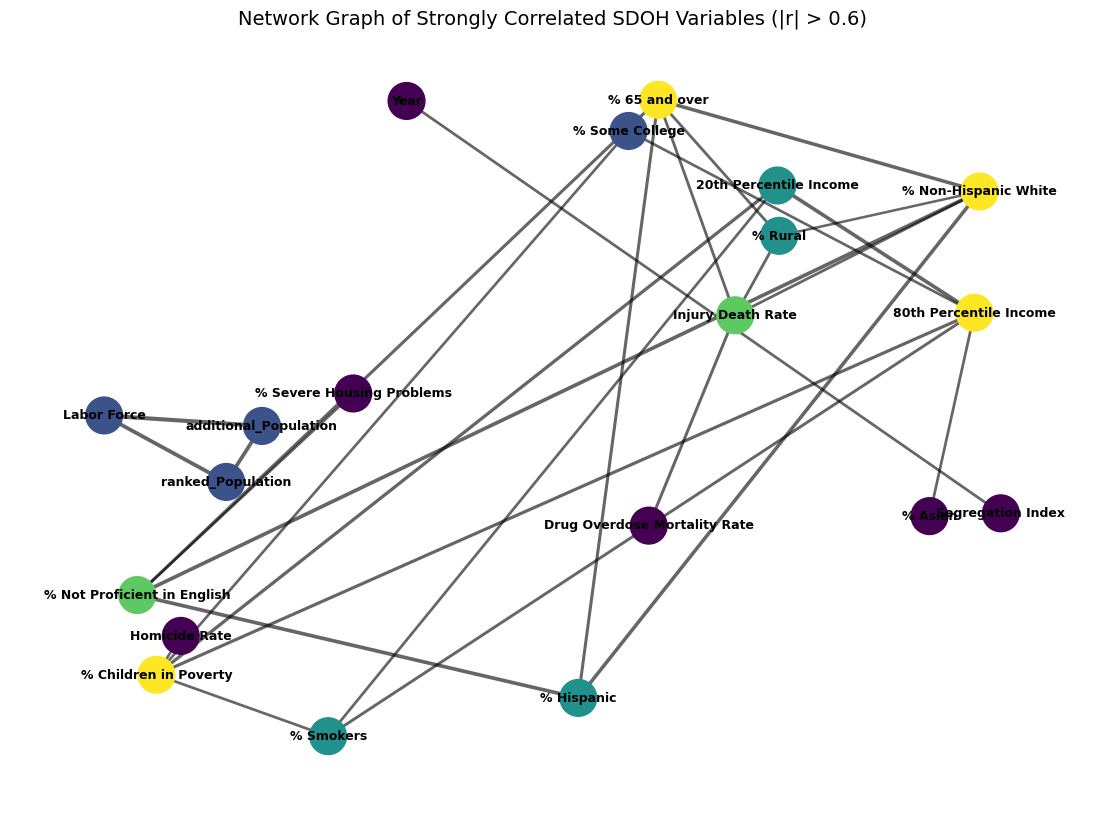

In [ ]:
#  correlation matrix
corr = mrsa_df.select_dtypes(include=[np.number]).corr()

# graph based on correlation strength 
threshold = 0.6  
edges = [(i, j, corr.loc[i, j]) for i in corr.columns for j in corr.columns if abs(corr.loc[i, j]) > threshold and i != j]

G = nx.Graph()
G.add_weighted_edges_from(edges)


plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=0.6)
centrality = nx.degree_centrality(G)
node_color = [centrality[node] for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_color, cmap='viridis')
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
nx.draw_networkx_edges(G, pos, width=[abs(G[u][v]['weight'])*3 for u,v in G.edges()], alpha=0.6)

plt.title("Network Graph of Strongly Correlated SDOH Variables (|r| > 0.6)", fontsize=14)
plt.axis("off")
plt.show()


# Dimension Reduction / Extracting Variables wiht the most variance with PCA

|Variable| VIF| Interpretation |Next:|
| ---------------------------------------------------------------------- | ------- | ----------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------- |
| **`additional_Population`** / **`Labor Force`**                        | ~6,800  | These two are basically the same thing — both measure county size.                              | keep `Labor Force` since it’s more relevant for per-capita analysis). |
| **`20th Percentile Income`, `80th Percentile Income`, `Income Ratio`** | 180–195 | All three describe income levels or inequality, so they overlap a lot.                          | Keep `Income Ratio`  since it directly shows income gap.      |
| **`% Hispanic`, `% Non-Hispanic White`, `% Asian`**                    | 36–130  | These add up to roughly 100%, so they’re naturally correlated.                                  | pick one group or combine them into a single diversity measure.                   |
| **`% Not Proficient in English`**                                      | 24      | Pretty similar to `% Hispanic`, so it’s not adding much new info.                               | drop.                         |
| **`Injury Death Rate`**                                                | 24      | Some overlap with `% Rural` or poverty measures — higher where access to care might be limited. | Probably keep it since it still captures an important health outcome.                        |
| **`% Rural`, `% Children in Poverty`, `% 65 and over`, `% Smokers`**   | 6–10    | These are moderately related but still distinct enough to keep.                                 | Keep all for now — they represent meaningful SDOH differences.                               |
                                                                  |

Scree plot shows: lots of reduancy between variables. PC 1 shows socioeconomic factors, PC2 shows healthcare access factors, and pc3 shows educaitonal/ factors


In [ ]:
# numeric columns only
numeric_df = mrsa_df.select_dtypes(include=[np.number]).dropna()

# data for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

# VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)

# pca
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_var_ratio = pca.explained_variance_ratio_
cum_var_ratio = np.cumsum(explained_var_ratio)

vif_data.head(15)


Variable          VIF
20        additional_Population  6895.855321
10                  Labor Force  6837.677199
5        20th Percentile Income   195.256645
6        80th Percentile Income   180.807451
23                   % Hispanic   129.985543
25         % Non-Hispanic White    99.172395
24                      % Asian    36.778274
4                  Income Ratio    34.617026
26  % Not Proficient in English    24.531377
19            Injury Death Rate    23.718462
3                % Some College    11.143049
21                      % Rural     9.882796
7         % Children in Poverty     9.158091
22                % 65 and over     8.572002
11                    % Smokers     6.474797

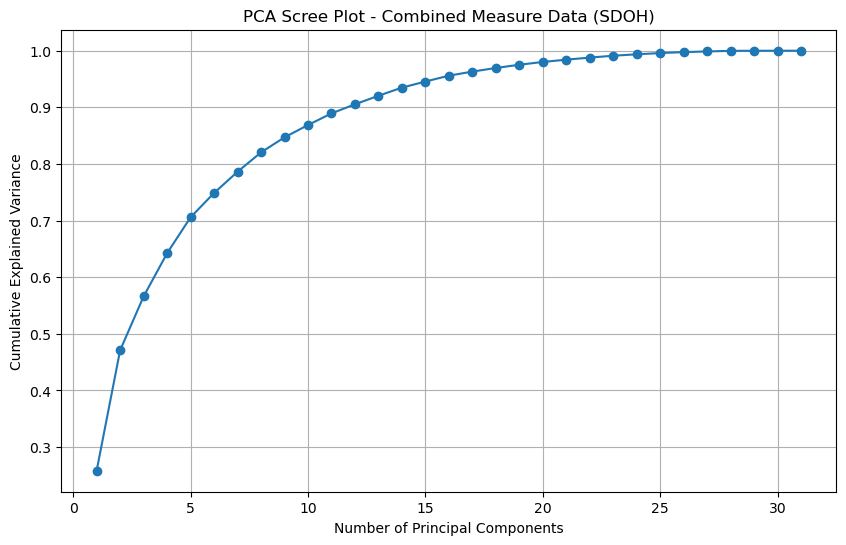

In [7]:
#scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var_ratio) + 1), cum_var_ratio, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot - Combined Measure Data (SDOH)")
plt.grid(True)
plt.show()


In [8]:
# Compute PCA loadings for interpretation
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=numeric_df.columns
)
#top 3 pcs
top_pcs = loadings.iloc[:, :3]

# Get top 5 features 
top_features = {}
for i in range(3):
    pc_name = f"PC{i+1}"
    sorted_loadings = top_pcs[pc_name].abs().sort_values(ascending=False)
    top_features[pc_name] = sorted_loadings.head(5).index.tolist()

summary_data = []
for i, pc in enumerate(top_features.keys(), 1):
    for feature in top_features[pc]:
        summary_data.append({
            "Principal Component": f"PC{i}",
            "Feature": feature,
            "Loading": loadings.loc[feature, f"PC{i}"]
        })

summary_loadings = pd.DataFrame(summary_data).sort_values(["Principal Component", "Loading"], ascending=[True, False])
summary_loadings.head(15)


Principal Component                      Feature   Loading
0                  PC1       80th Percentile Income  0.324950
1                  PC1               % Some College  0.296577
2                  PC1       20th Percentile Income  0.295614
4                  PC1        % Children in Poverty -0.293727
3                  PC1                    % Smokers -0.294787
5                  PC2         % Non-Hispanic White  0.362677
8                  PC2                % 65 and over  0.324915
9                  PC2    % Severe Housing Problems -0.290314
7                  PC2                   % Hispanic -0.327895
6                  PC2  % Not Proficient in English -0.347502
10                 PC3                  Labor Force  0.474522
11                 PC3        additional_Population  0.474423
12                 PC3            ranked_Population  0.452389
14                 PC3                 Income Ratio  0.193679
13                 PC3                         FIPS -0.298910

# Trends for SDOH factors over the years (Stability Analysis)

Variables with high variability (e.g., ranked Population, % Unemployed, Segregation Index, PM2.5, % Uninsured, % Smokers, % Physically Inactive)
show large fluctuations across years. This could indicate either:

-  signal: rapid social, economic, or environmental changes that might directly influence MRSA infection risk (for example, unemployment spikes or pollution surges).

- noise: measurement inconsistencies, re-scaling, or methodological changes that don’t reflect real shifts.

    - Because of this ambiguity, these features should be closely monitored and potentially transformed (e.g., year-normalized, smoothed, or lagged) before inclusion in predictive models.

- Moderately variable variables (e.g., % Children in Poverty, Drug Overdose Mortality Rate, Income Percentiles)
change more gradually and likely capture true socioeconomic trends that evolve over time. These are strong candidates for inclusion as predictors in modeling MRSA rates.

- Stable variables (e.g., Labor Force)
exhibit minimal year-to-year fluctuation, suggesting structural consistency in county characteristics. These are valuable as control variables or baselines, providing context for interpreting other predictors’ changes.

C:\Users\Alan\AppData\Local\Temp\ipykernel_29744\1901285528.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_yoy = df_yearly.pct_change() * 100  # percent change


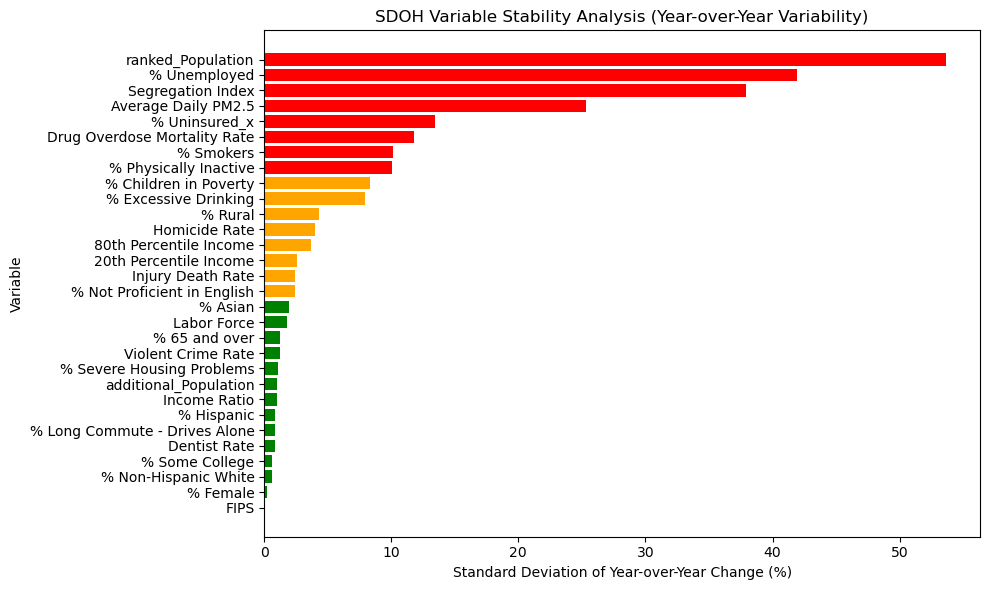

Mean YOY Change (%)  Std YOY Change (%)  \
ranked_Population                       21.250122           53.644893   
% Unemployed                            -0.630046           41.931704   
Segregation Index                      -13.852400           37.890996   
Average Daily PM2.5                      1.873895           25.331509   
% Uninsured_x                           -6.647152           13.441221   
Drug Overdose Mortality Rate             6.245505           11.776575   
% Smokers                                1.026018           10.173505   
% Physically Inactive                    2.758992           10.029902   
% Children in Poverty                   -4.207688            8.354138   
% Excessive Drinking                    -0.688527            7.944776   
% Rural                                  1.624542            4.298135   
Homicide Rate                            1.183624            4.039334   
80th Percentile Income                   4.576255            3.662494   
20th Percentile Income                   5.136493            2.601439   
Injury Death Rate                        2.317892            2.465724   

                                     Stability Class  
ranked_Population             Highly Variable (>10%)  
% Unemployed                  Highly Variable (>10%)  
Segregation Index             Highly Variable (>10%)  
Average Daily PM2.5           Highly Variable (>10%)  
% Uninsured_x                 Highly Variable (>10%)  
Drug Overdose Mortality Rate  Highly Variable (>10%)  
% Smokers                     Highly Variable (>10%)  
% Physically Inactive         Highly Variable (>10%)  
% Children in Poverty               Moderate (2–10%)  
% Excessive Drinking                Moderate (2–10%)  
% Rural                             Moderate (2–10%)  
Homicide Rate                       Moderate (2–10%)  
80th Percentile Income              Moderate (2–10%)  
20th Percentile Income              Moderate (2–10%)  
Injury Death Rate                   Moderate (2–10%)

In [ ]:
# yearly means
df_yearly = mrsa_df.groupby("Year").mean(numeric_only=True).sort_index()

# yoy % Changes
df_yoy = df_yearly.pct_change() * 100  # percent change
df_yoy = df_yoy.dropna(how='all')      

# stability
summary = pd.DataFrame({
    "Mean YOY Change (%)": df_yoy.mean(),
    "Std YOY Change (%)": df_yoy.std()
})

# thresholds
stable_thresh = 2
variable_thresh = 10

summary["Stability Class"] = summary["Std YOY Change (%)"].apply(
    lambda s: "Stable (<2%)" if s < stable_thresh else (
        "Moderate (2–10%)" if s < variable_thresh else "Highly Variable (>10%)"
    )
)

# sort 
summary = summary.sort_values("Std YOY Change (%)", ascending=False)

plt.figure(figsize=(10, 6))
colors = summary["Stability Class"].map({
    "Stable (<2%)": "green",
    "Moderate (2–10%)": "orange",
    "Highly Variable (>10%)": "red"
})
plt.barh(summary.index, summary["Std YOY Change (%)"], color=colors)
plt.xlabel("Standard Deviation of Year-over-Year Change (%)")
plt.ylabel("Variable")
plt.title("SDOH Variable Stability Analysis (Year-over-Year Variability)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

summary.head(15)
